###  Arken yrken

De personer > 3300 som kopplats till Wikidata söks igenom och yrket hämtas från Arken via webscraping 
* Wikidata [P8899](https://www.wikidata.org/wiki/Property_talk:P8899)
* [T269064](https://phabricator.wikimedia.org/T269064) "Kungliga biblioteket Arken - new WD property"

Har ej hittat diskusionsgrupp för Arken, API eller annat matnyttigt

#### Other sources we sync
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 


In [1]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2021-08-22 08:44:50.197599


In [2]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

queryArken = """SELECT ?item ?itemLabel ?arkenid WHERE {
  ?item wdt:P8899 ?arkenid.
  ?item wdt:P31 wd:Q5.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "sv". }
} limit 30000"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDArkentot = get_sparql_dataframe(endpoint_url, queryArken)
WDArkentot["Source"] = "Arken"

In [3]:
WDArkentot.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item       3316 non-null   object
 1   itemLabel  3316 non-null   object
 2   arkenid    3316 non-null   object
 3   Source     3316 non-null   object
dtypes: object(4)
memory usage: 103.8+ KB


In [4]:
WDArkentot.head(5) 

,item,itemLabel,arkenid,Source
0,http://www.wikidata.org/entity/Q380517,Claudio Merulo,kongelige-bibliotek,Arken
1,http://www.wikidata.org/entity/Q560790,Alfred Nathorst,nathorst-alfred-gabriel,Arken
2,http://www.wikidata.org/entity/Q569387,Rutger von Ascheberg,"Ascheberg,-Rutger-von",Arken
3,http://www.wikidata.org/entity/Q581361,Jens Juel,"Juel,-Jens",Arken
4,http://www.wikidata.org/entity/Q636426,Carl Olof Rosenius,rosenius-carl-olof,Arken


In [5]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup, NavigableString, Tag
from tqdm.notebook import tqdm  

newList = []
urlBase = "https://arken.kb.se/"
for index, row in tqdm(WDArkentot.iterrows(), total=WDArkentot.shape[0]):    
    #time.sleep(5)
    arkenid = row['arkenid']
    person = row['itemLabel']    
    url = urlBase + arkenid
    #print(url)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    for header in soup.find_all('h3'): 
        try:
            if "Yrken" in header:
                #print (arkenid,"\tyrke: ",header)
                div_tag = header.parent
                for link in div_tag.find_all('a'):
                    new_item = dict()
                    new_item["arkenid"] = arkenid
                    new_item["person"] = person
                    new_item["yrke"] =  link.get_text()
                    #print("\t",person,"\t",arkenid,"\t",link.get_text())
                    newList.append(new_item)
        except Exception as e:
            print(e)
print("Lines found:\t", len(newList))    
# TBD
    

  0%|          | 0/3316 [00:00<?, ?it/s]

Lines found:	 3644


In [6]:
#newList

In [7]:
import pandas as pd
newListdf = pd.DataFrame(newList,columns=list(["arkenid","person","yrke"]))

In [8]:
newListdf

,arkenid,person,yrke
0,nathorst-alfred-gabriel,Alfred Nathorst,Forskare
1,"Ascheberg,-Rutger-von",Rutger von Ascheberg,Militärer
2,"Ascheberg,-Rutger-von",Rutger von Ascheberg,Ämbetsmän
3,"Juel,-Jens",Jens Juel,Konstnärer
4,rosenius-carl-olof,Carl Olof Rosenius,Präster
...,...,...,...
3639,"Essen,-Fredrik-von",Fredrik von Essen,Politiker
3640,"Acke,-J-A-G",J.A.G. Acke,Konstnärer
3641,ahlgrensson-bjorn,Björn Ahlgrensson,Konstnärer
3642,"Ameen,-Georg-Fredrik",Georg Fredrik Ameen,Författare


In [9]:
yrkendf = pd.concat([pd.Series(row['yrke'].split(','))              
                    for _, row in newListdf.iterrows()]).reset_index() 
yrkendf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   3644 non-null   int64 
 1   0       3644 non-null   object
dtypes: int64(1), object(1)
memory usage: 57.1+ KB


In [10]:
mapping = {yrkendf.columns[1]:'yrke'}
yrkendf = yrkendf.rename(columns=mapping)
yrkendf["yrke"] = yrkendf['yrke'].str.strip()
yrkenArken = yrkendf["yrke"].value_counts() 
yrkenArken

Författare        860
Konstnärer        274
Professorer       229
Politiker         158
Journalister      138
                 ... 
Lantmätare          1
Sångpedagog         1
Landshövdingar      1
Idrottare           1
Mecenater           1
Name: yrke, Length: 97, dtype: int64

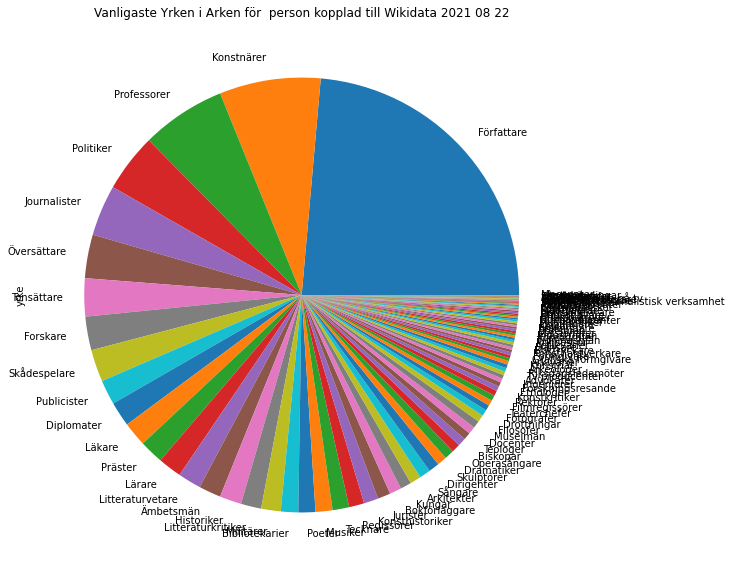

In [11]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10, 10))
#plt.rcParams["figure.figsize"] = (10,10)
ax = yrkenArken.plot(kind='pie')

ax.set_title("Vanligaste Yrken i Arken för  person kopplad till Wikidata " + start_time.strftime('%Y %m %d'))
plt.show()

In [12]:
import matplotlib.pyplot
#plt.rcParams['savefig.facecolor']='white'
#fig=plt.figure()
fig.savefig("../img/Arken_yrken.png", dpi=100)
#plt.savefig("../img/Arken_yrken.png")


In [13]:
yrkenArken.to_csv("Arken_yrken_value_counts.csv")

In [14]:
end_time  = datetime.now()
print("Last run: ", end_time)

Last run:  2021-08-22 08:54:08.177183
